In [1]:
#Python Default 

import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

import pickle
import time
import random

#Essentials

import numpy as np
from bs4 import BeautifulSoup
import requests
import func_timeout
import pandas as pd

#from objproxies import *

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

#Qiskit

from qiskit.circuit import Gate
from qiskit.circuit.library import *
from qiskit import transpile
from qiskit.providers.models import *
from qiskit_ibm_runtime.fake_provider import *
from qiskit.providers.fake_provider import *
from qiskit.quantum_info import Statevector

## Qiskit Nature
    
from qiskit_nature.units import *   #ANGSTROM

from qiskit_nature.second_q.drivers import *    #PySCFDriver

from qiskit_nature.second_q.mappers import * #JordanWignerMapper

from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_nature.second_q.problems import ElectronicStructureProblem

from qiskit_nature.second_q.circuit.library import *  #Ansatz, HF


## Qiskit Algorithms
    
from qiskit_algorithms.minimum_eigensolvers import VQE as  VQE_algorithms   #VQE
 
from qiskit_algorithms.optimizers import *    #SLSQP

from qiskit.circuit.library import EfficientSU2   #EfficientSU2

## Qiskit Primitives

from qiskit.primitives import Estimator as Estimator_Nature

from qiskit_aer.primitives.estimator import Estimator as Estimator_Aer

## Qiskit Noise Models

from qiskit_aer.noise import NoiseModel

from qiskit.providers.fake_provider import *

##Qiskit Runtime IBM

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options

from qiskit_ibm_runtime import Estimator, EstimatorV2    #Estimator

## Braket

from braket.tracking import Tracker
from qiskit_braket_provider import *


%matplotlib widget
#%matplotlib inline

In [2]:
provider = BraketProvider()
local_simulator = BraketLocalBackend()
sv1_simualtor = provider.get_backend("SV1")

In [4]:
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(backend)
coupling_map = backend.configuration().coupling_map

In [3]:
driver = PySCFDriver(
    atom= f"H 0 0 0; H 0 0 1",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

#estimator = Estimator(backend = local_simulator, options={"shots" : 2000, "noise_model" : noise_model, "coupling_map" : coupling_map})

estimator = Estimator(backend = local_simulator)


mapper = JordanWignerMapper()

ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

vqe_solver = VQE_algorithms(estimator, ansatz, COBYLA())

vqe_solver.initial_point = [0.0] * ansatz.num_parameters

calc = GroundStateEigensolver(mapper, vqe_solver)

minimum_eigenvalue = vqe_solver.compute_minimum_eigenvalue(calc.get_qubit_operators(es_problem)[0])

res = calc.solve(es_problem)

resultado_final = res.groundenergy

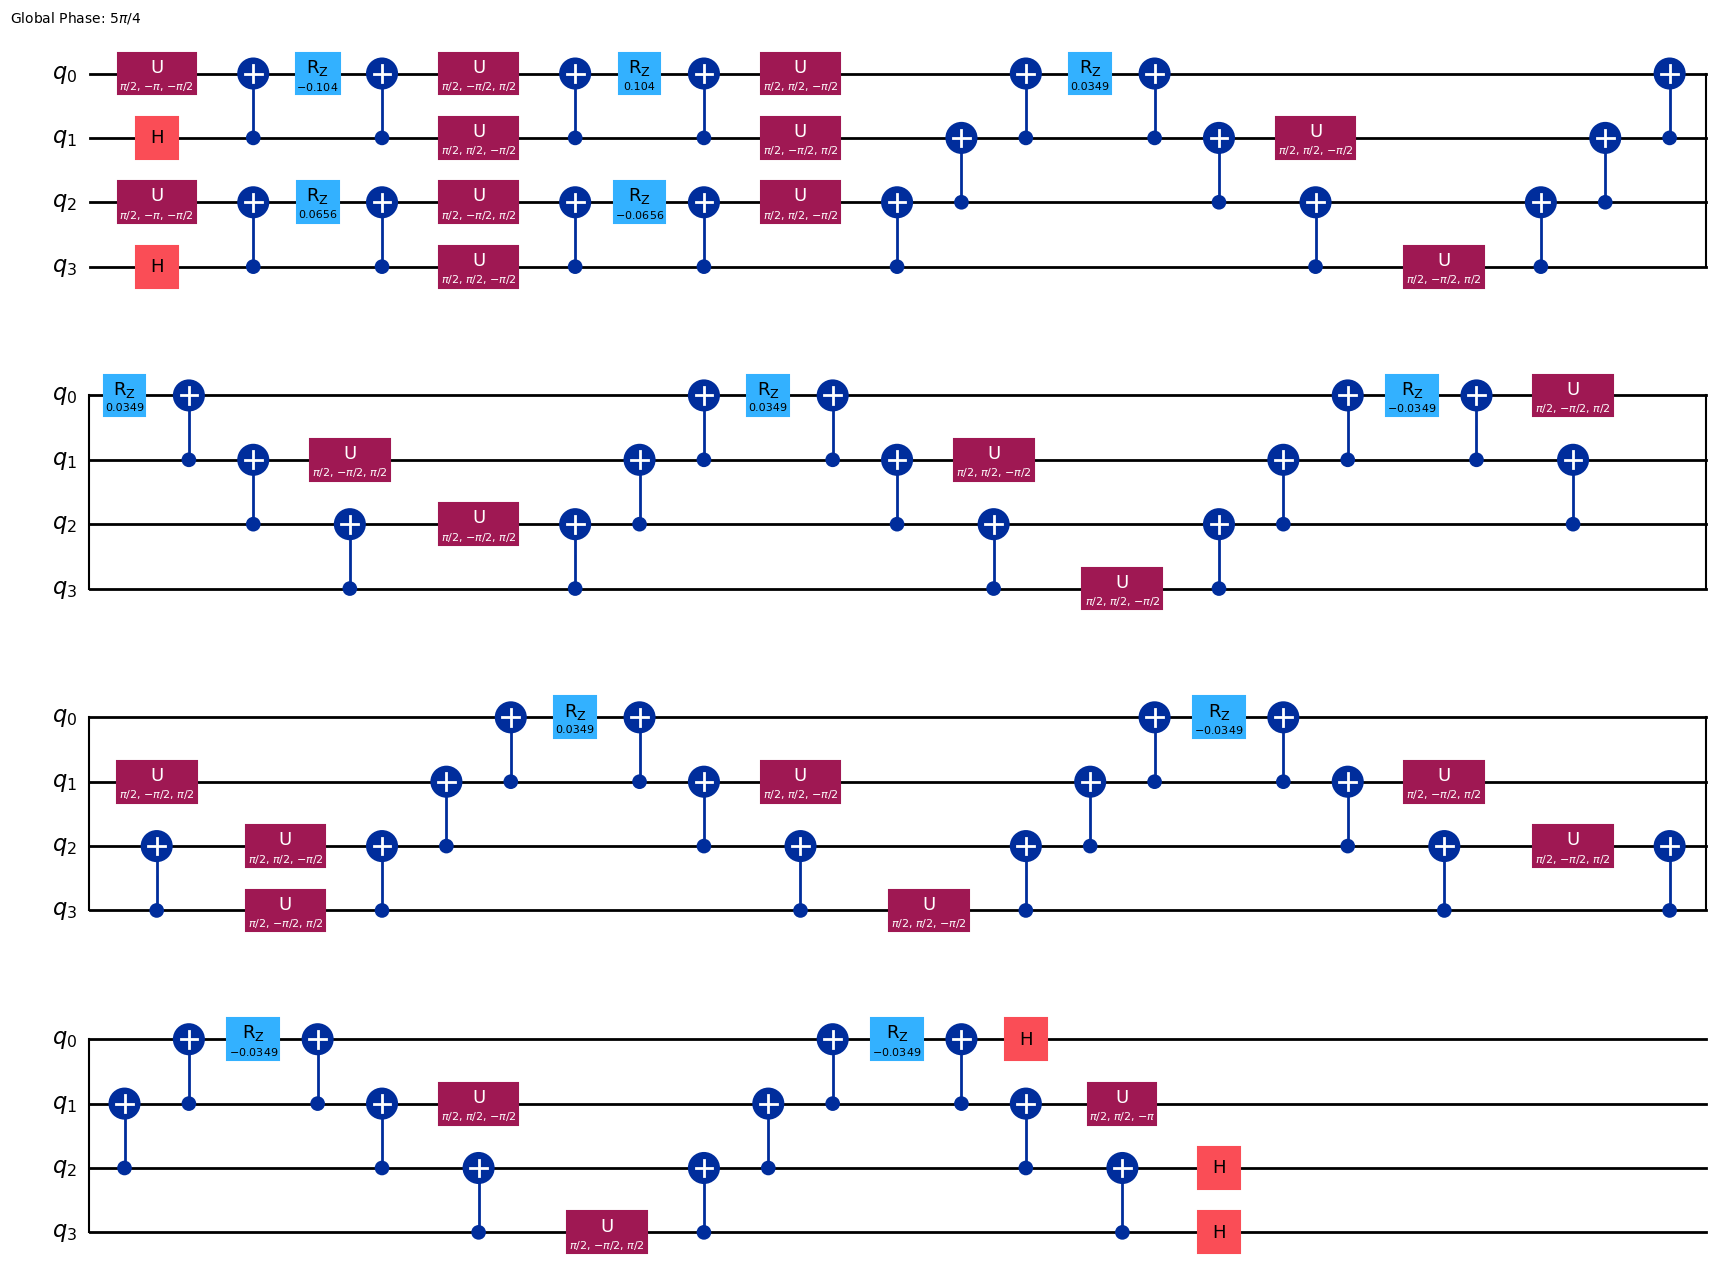

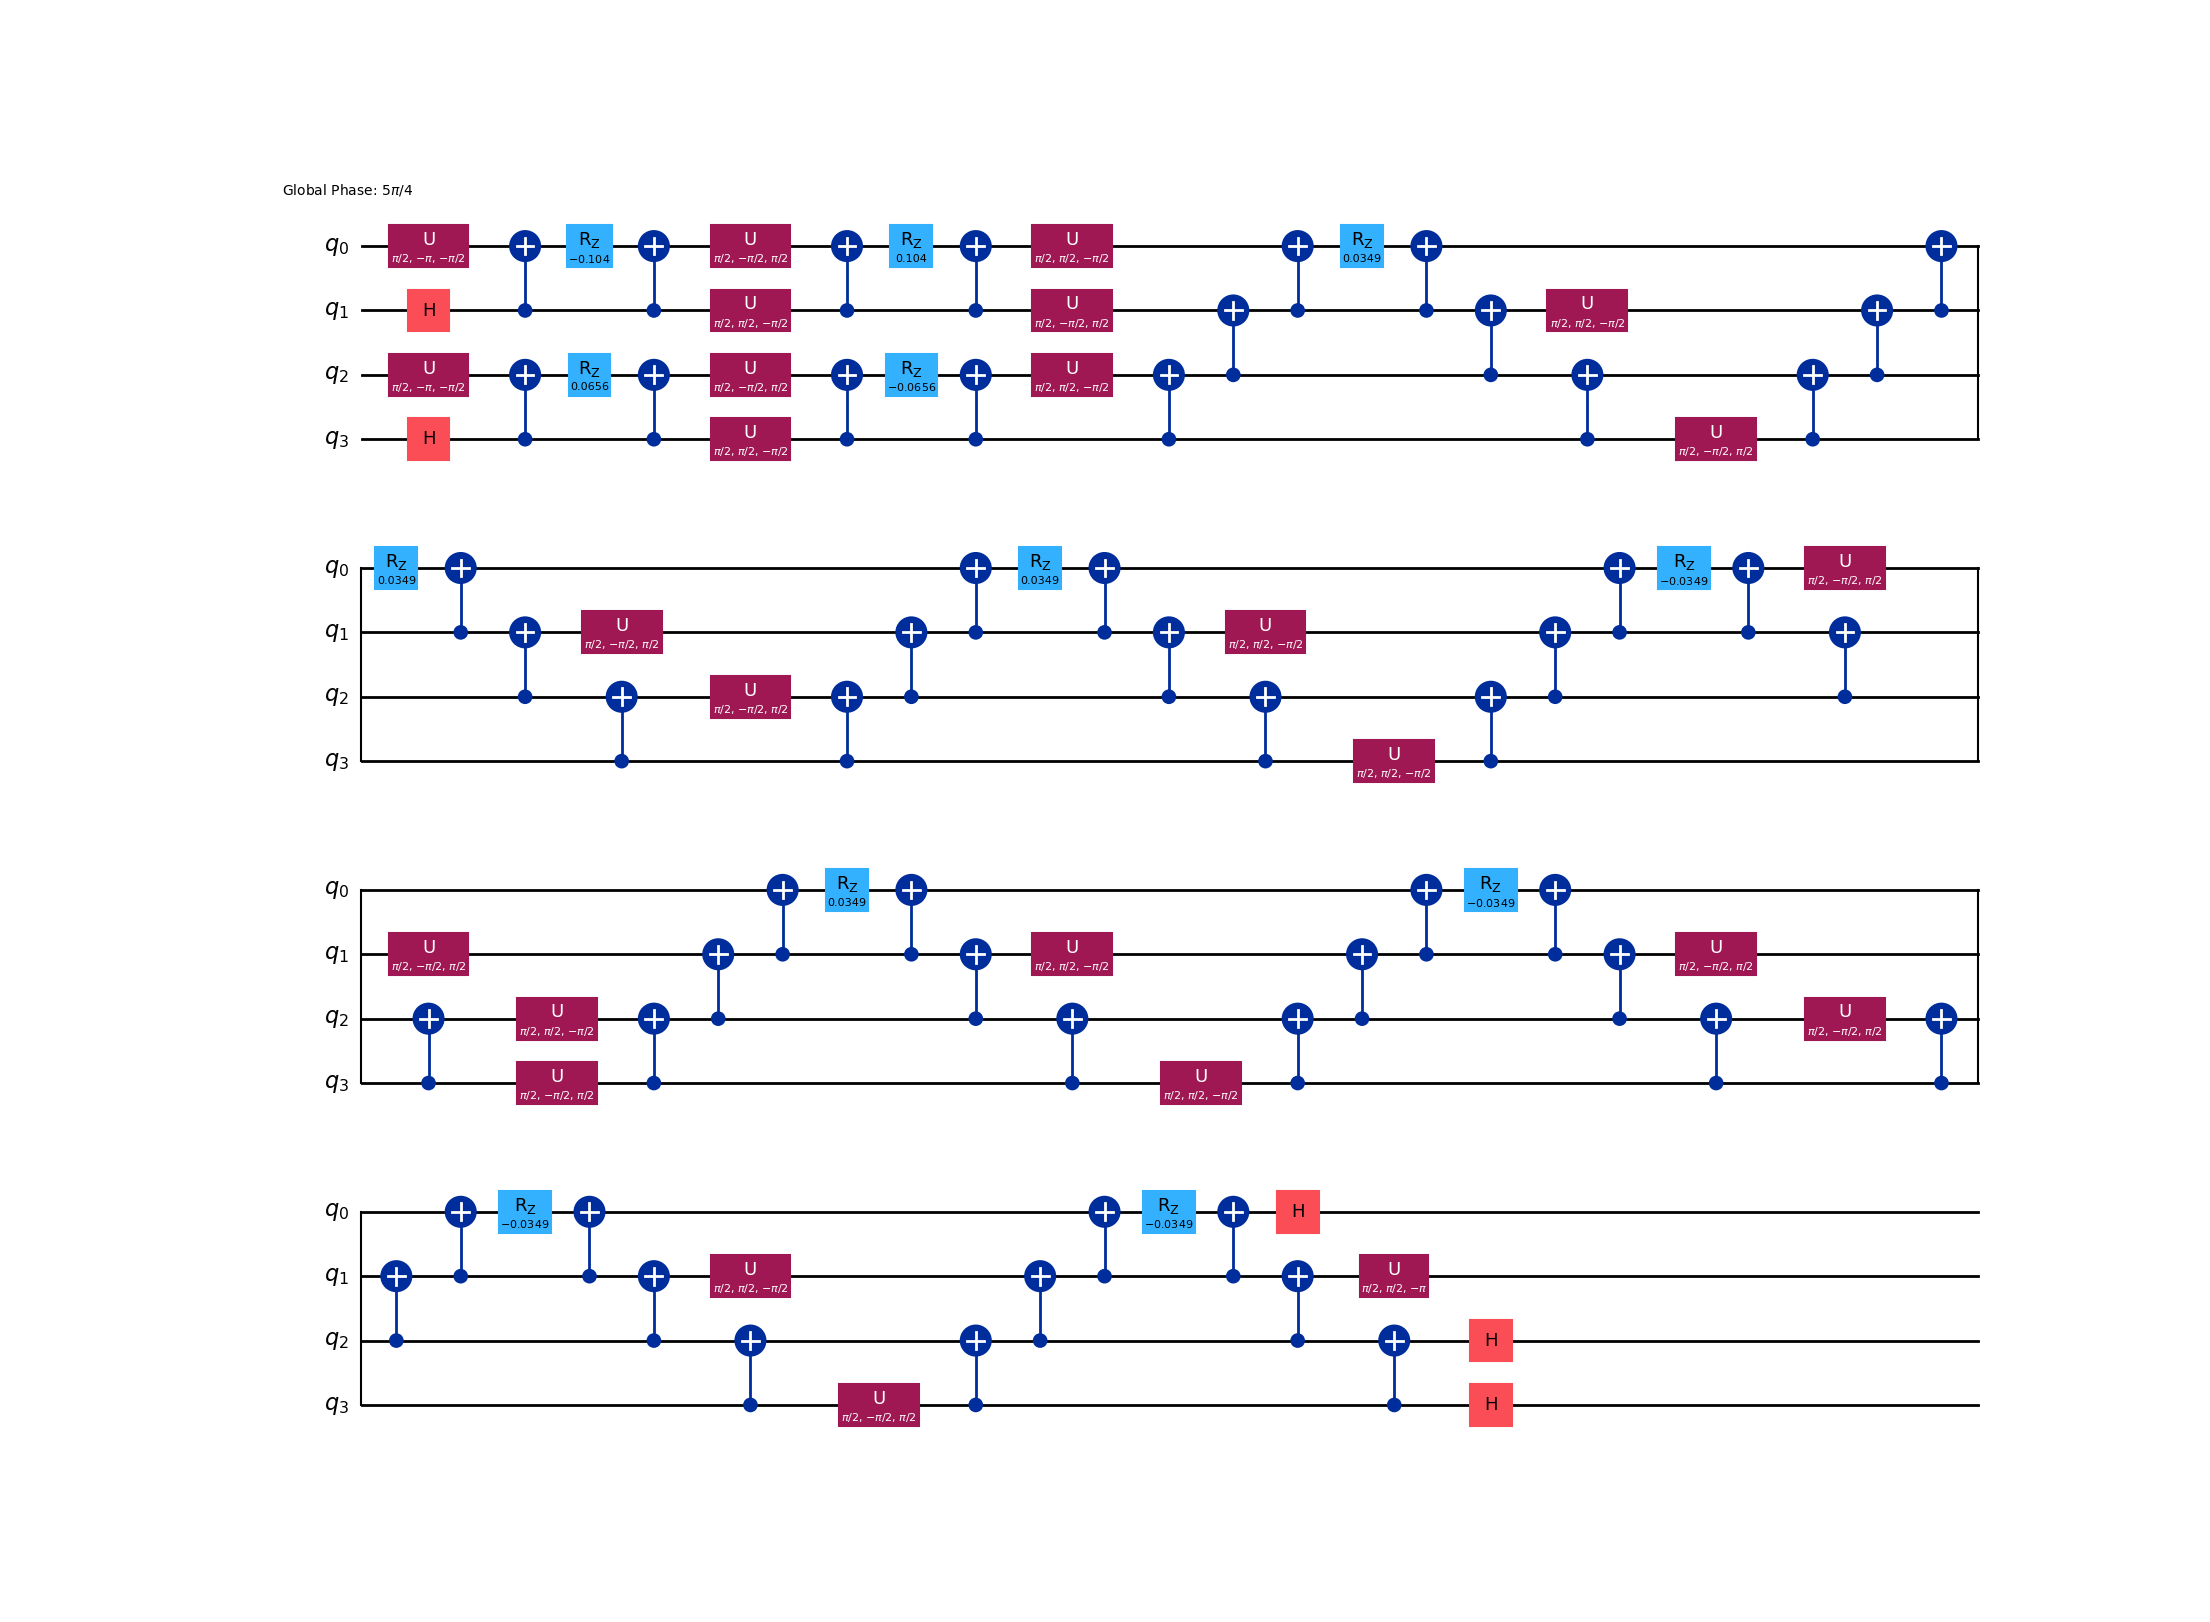

In [4]:
circuito = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), local_simulator)

circuito.draw(output = "mpl")  

In [5]:
gates = []

for i, (gate, qubits, etc) in enumerate(circuito.data):
    
    gates.append(gate.name)

set_gates = list(set(gates))

set_gates.sort(key = lambda x: gates.count(x), reverse = True)

print("Gates present: " + " ".join(set_gates), end = "\n\n")
print(f"Number of gates: {len(gates)}\n\nDistribution of gates: \n")

for i in set_gates:
    
    print(i, gates.count(i))

Gates present: cx u rz h

Number of gates: 99

Distribution of gates: 

cx 56
u 26
rz 12
h 5


In [6]:
def salvar(a):
    with open(f'AWS/Gabriel/GroundState1/dados/{a}.pickle', 'wb') as f:
        pickle.dump(eval(a), f) 

def abrir(a):
    with open(f'AWS/Gabriel/GroundState1/dados/{a}.pickle', 'rb') as f:
        return pickle.load(f)
    

def clifford_gate():

   random_value = random.randint(0, 3)
   
   return RZGate(random_value*np.pi/2)

def subs_ncg(quantum_circuit, n):
    
   quantum_circuit = quantum_circuit.copy()

   n = int(n * quantum_circuit.size())

   non_permitted_gates = ["cx"]

   gates_to_change = random.sample(range(0, quantum_circuit.size()+1), n)

   for i, (gate, *qubits) in enumerate(quantum_circuit.data):
      
      if i in gates_to_change:
      
         if gate.name not in non_permitted_gates:
            
            quantum_circuit.data[i] = (clifford_gate(), *qubits)

         else:
            
            new_gate = random.randint(i, len(quantum_circuit.data)-1)
            
            #while quantum_circuit.data[new_gate][0].name in non_permitted_gates or new_gate in gates_to_change:
            while quantum_circuit.data[new_gate][0].name in non_permitted_gates:
                
                new_gate = random.randint(i, len(quantum_circuit.data)-1)

            quantum_circuit.data[new_gate] = (clifford_gate(), *quantum_circuit.data[new_gate][1:])

   return quantum_circuit

def run_statevector(circuit, driver, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   estado = Statevector.from_instruction(circuit)
   
   expectation_value = estado.expectation_value(mapper.map(hamiltoniano))
   
   return expectation_value.real

def run_estimator(circuit, driver, backend, shots = 2000, noise_model = None, coupling_map = None, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   if noise_model is not None:
      
      estimator = Estimator(backend = backend, options = {"shots" : shots, "noise_model" : noise_model, "coupling_map" : coupling_map})
   
   else :
      
      estimator = Estimator(backend = backend, options = {"shots" : shots})
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

def check (original, target, driver, difference_percentage = 0.1):
   
   original, target = run_statevector(original, driver), run_statevector(target, driver)
   
   return abs(original - target) < difference_percentage * abs(original)

def modelo_1(original_circuit, number_of_circuits, driver, percentage_of_changed_gates = 0.3, difference_percentage = 0.5, do_check = True):
   
   while number_of_circuits > 0:
      
      number_of_circuits -= 1
      
      new_circuit = subs_ncg(original_circuit, percentage_of_changed_gates)
      
      if do_check and check(original_circuit, new_circuit, driver, difference_percentage):
         
         yield new_circuit
         
      else :
         
         yield None
         
   

In [48]:
circuitos_similares = list(modelo_1(circuito, 50000, es_problem, percentage_of_changed_gates = 0.3, difference_percentage = 0.3, do_check=True))

circuitos_similares = list(filter(None, circuitos_similares))

print(len(circuitos_similares))

1026


In [7]:
circuitos_similares = abrir("circuitos_similares")

In [8]:
original_expectation_value = run_statevector(circuito, es_problem)
original_gate_counts = {gate.name: sum(1 for g, *_ in circuito.data if g.name == gate.name) for gate, *_ in circuito.data}

data = []
for circuit in circuitos_similares:
    row = {}
    row['circuit'] = hex(id(circuit))  
    row['num_gates'] = circuit.size()
    gate_counts = {gate.name: sum(1 for g, *_ in circuit.data if g.name == gate.name) for gate, *_ in circuit.data}
    row['gate_counts'] = dict(sorted(gate_counts.items(), key=lambda item: item[1], reverse=True))
    changed_gates = {gate: gate_counts.get(gate, 0) - original_gate_counts.get(gate, 0) for gate in set(gate_counts) | set(original_gate_counts)}
    row['changed_gates'] = dict(sorted(changed_gates.items(), key=lambda item: item[1], reverse=True))
    data.append(row)
    row['rz_gates'] = row['gate_counts'].get('rz', 0)  
    row['expected_value'] = run_statevector(circuit, es_problem)
    row['percentage_difference'] = f"{abs(abs(row['expected_value'] - original_expectation_value) / original_expectation_value)* 100:.2f}%"

df = pd.DataFrame(data)

df

,circuit,num_gates,gate_counts,changed_gates,rz_gates,expected_value,percentage_difference
0,0x7f63a8257a40,99,"{'cx': 56, 'rz': 29, 'u': 13, 'h': 1}","{'rz': 17, 'cx': 0, 'h': -4, 'u': -13}",29,-1.387415,14.55%
1,0x7f63a823f470,99,"{'cx': 56, 'rz': 31, 'u': 11, 'h': 1}","{'rz': 19, 'cx': 0, 'h': -4, 'u': -15}",31,-1.333247,17.89%
2,0x7f63e715c440,99,"{'cx': 56, 'rz': 24, 'u': 17, 'h': 2}","{'rz': 12, 'cx': 0, 'h': -3, 'u': -9}",24,-1.161957,28.44%
3,0x7f63c80e99a0,99,"{'cx': 56, 'rz': 30, 'u': 13}","{'rz': 18, 'cx': 0, 'h': -5, 'u': -13}",30,-1.188365,26.81%
4,0x7f63a823e120,99,"{'cx': 56, 'rz': 29, 'u': 12, 'h': 2}","{'rz': 17, 'cx': 0, 'h': -3, 'u': -14}",29,-1.145406,29.46%
...,...,...,...,...,...,...,...
1021,0x7f634339df70,99,"{'cx': 56, 'rz': 26, 'u': 14, 'h': 3}","{'rz': 14, 'cx': 0, 'h': -2, 'u': -12}",26,-1.226199,24.48%
1022,0x7f63433b8260,99,"{'cx': 56, 'rz': 26, 'u': 15, 'h': 2}","{'rz': 14, 'cx': 0, 'h': -3, 'u': -11}",26,-1.159880,28.57%
1023,0x7f63433ba540,99,"{'cx': 56, 'rz': 29, 'u': 12, 'h': 2}","{'rz': 17, 'cx': 0, 'h': -3, 'u': -14}",29,-1.271984,21.66%
1024,0x7f63433cc860,99,"{'cx': 56, 'rz': 28, 'u': 15}","{'rz': 16, 'cx': 0, 'h': -5, 'u': -11}",28,-1.139513,29.82%


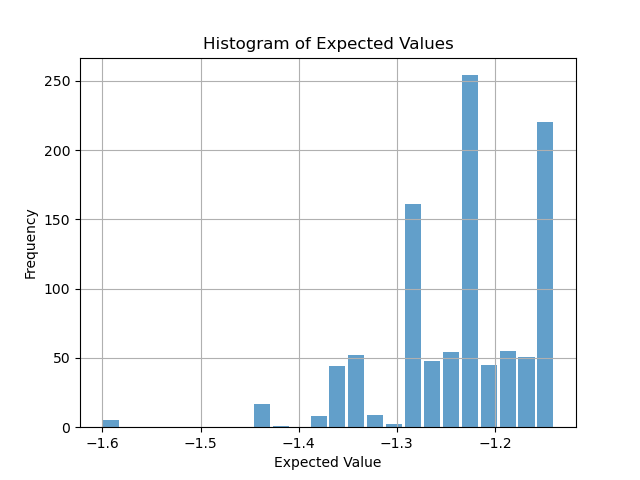

In [14]:
expected_values = df['expected_value']

plt.figure()
plt.hist(list(expected_values), bins='auto', alpha=0.7, rwidth=0.85)
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title('Histogram of Expected Values')
plt.grid(True)

plt.show()